### Introducción
Este proyecto implementa un análisis comparativo de diferentes modelos de clasificación (Naive Bayes y SVM) para predecir respuestas basadas en un conjunto de datos de preguntas y respuestas, utilizando datos de interacciones reales con usuarios. Se enfoca en evaluar la eficiencia y precisión de los modelos en el contexto de un bot de Discord.

### Librerias Necesarias para realizar el análisis y comparación

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Input, Dense # type: ignore
import csv
import seaborn as sns

### Carga y Preparación de datos

In [2]:
# Cargar los archivos CSV
# questions_and_answers_df: contiene pares de preguntas y respuestas para entrenamiento
# interactions_df: contiene datos de interacciones para pruebas
questions_and_answers_df = pd.read_csv('questions_and_answers_V2.csv')
interactions_df = pd.read_csv('interactions.csv')

# Preparación de datos
# Vectorización de preguntas usando TF-IDF para convertir texto a formato numérico que pueda ser procesado por modelos de ML
questions = questions_and_answers_df['question'].astype(str).fillna('').values
interactions = interactions_df['question'].astype(str).fillna('').values


### Vectorización de Texto

In [3]:
# Vectorización inicial usando TF-IDF para entradas del autoencoder
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(questions).toarray() # type: ignore
X_test_tfidf = vectorizer.transform(interactions).toarray() # type: ignore

### Autoencoder

In [4]:
# Configuración y definición de un autoencoder para la reducción de dimensionalidad
# Este paso es crucial para manejar eficientemente grandes volúmenes de datos
input_dim = X_train_tfidf.shape[1]
encoding_dim = 20

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [5]:
# Entrenamiento del autoencoder utilizando los datos de entrenamiento
autoencoder.fit(X_train_tfidf, X_train_tfidf, epochs=200, batch_size=16, shuffle=True, validation_split=0.2)

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6916 - val_loss: 0.6867
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6861 - val_loss: 0.6808
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6804 - val_loss: 0.6742
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6735 - val_loss: 0.6666
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6660 - val_loss: 0.6579
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6571 - val_loss: 0.6477
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6465 - val_loss: 0.6358
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6336 - val_loss: 0.6218
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6199 - val_loss: 0.6057
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6018 - val_loss: 0.5873
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5823 - val_loss: 0.5663
Epoch 12/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5624 - val_loss: 0.5431


In [6]:
# Codificación de los datos
encoder_model = Model(inputs=input_layer, outputs=encoder)
X_train_encoded = encoder_model.predict(X_train_tfidf)
X_test_encoded = encoder_model.predict(X_test_tfidf)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


### Evaluación de datos

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Modelo 1: Naive Bayes
model_nb = MultinomialNB()
model_nb.fit(X_train_encoded, questions_and_answers_df['answer'])
y_pred_nb = model_nb.predict(X_test_encoded)

# Modelo 2: SVM
model_svm = SVC(kernel='linear')
model_svm.fit(X_train_encoded, questions_and_answers_df['answer'])
y_pred_svm = model_svm.predict(X_test_encoded)

In [8]:
# Comparación de la precisión de ambos modelos
accuracy_nb = accuracy_score(interactions_df['answer'], y_pred_nb)
accuracy_svm = accuracy_score(interactions_df['answer'], y_pred_svm)

In [9]:
report_nb = classification_report(interactions_df['answer'], y_pred_nb,zero_division=0)
print("Precisión Naive Bayes:", accuracy_nb)
print("Classification Report Naive Bayes:\n", report_nb)

Precisión Naive Bayes: 0.18
Classification Report Naive Bayes:
                                                                                                                 precision    recall  f1-score   support

                       Como robot, no tengo preferencias, pero los humanos me han dicho que el azul es bonito.       0.00      0.00      0.00         8
                                                    El amor es un concepto humano complejo que no experimento.       0.00      0.00      0.00         0
                          El futuro es emocionante y lleno de posibilidades para la tecnología y la humanidad.       0.00      0.00      0.00         0
                                              Hola, estoy bien, gracias por preguntar. ¿En qué puedo ayudarte?       0.00      0.00      0.00        15
                               Manejo los conflictos analizando la situación y proponiendo soluciones lógicas.       0.00      0.00      0.00         0
                       

In [10]:
report_svm = classification_report(interactions_df['answer'], y_pred_svm,zero_division=0)
print("Precisión SVM:", accuracy_svm)
print("Classification Report SVM:\n", report_svm)

Precisión SVM: 0.27
Classification Report SVM:
                                                                                                                 precision    recall  f1-score   support

                       Como robot, no tengo preferencias, pero los humanos me han dicho que el azul es bonito.       0.00      0.00      0.00         8
                                              Hola, estoy bien, gracias por preguntar. ¿En qué puedo ayudarte?       0.00      0.00      0.00        15
                                          La educación es fundamental para el crecimiento y desarrollo humano.       0.00      0.00      0.00         0
                                Me mantengo actualizado mediante procesos de aprendizaje automático continuos.       0.00      0.00      0.00         3
                                                             Me siento joven cuando aprendo algo nuevo y útil.       0.00      0.00      0.00         0
                                       

### Comparación de las respuestas del modelo con los reales

In [11]:
def compare_responses_to_csv(interactions_df, nb_model, svm_model, encoder_model, vectorizer, output_file):
    """
    Compara las respuestas reales con las predicciones y guarda los resultados en un CSV.
    """
    comparisons = []
    for index, row in interactions_df.iterrows():
        user_question = row['question']
        true_response = row['answer']
        user_question_vectorized = vectorizer.transform([user_question]).toarray()
        user_question_encoded = encoder_model.predict(user_question_vectorized)
        nb_response = nb_model.predict(user_question_encoded)[0]
        svm_response = svm_model.predict(user_question_encoded)[0]
        comparisons.append({
            'Interaction': index + 1,
            'User': user_question,
            'True Response': true_response,
            'Naive Bayes Response': nb_response,
            'SVM Response': svm_response
        })
    
    keys = comparisons[0].keys()
    with open(output_file, 'w', newline='', encoding='utf-8') as output_csv:
        dict_writer = csv.DictWriter(output_csv, fieldnames=keys)
        dict_writer.writeheader()
        dict_writer.writerows(comparisons)

# Generar y guardar las respuestas comparativas
output_file = 'comparative_responses.csv'
compare_responses_to_csv(interactions_df, model_nb, model_svm, encoder_model, vectorizer, output_file)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

In [12]:
# Cargar los datos del archivo CSV comparativo
comparative_responses_df = pd.read_csv('comparative_responses.csv')

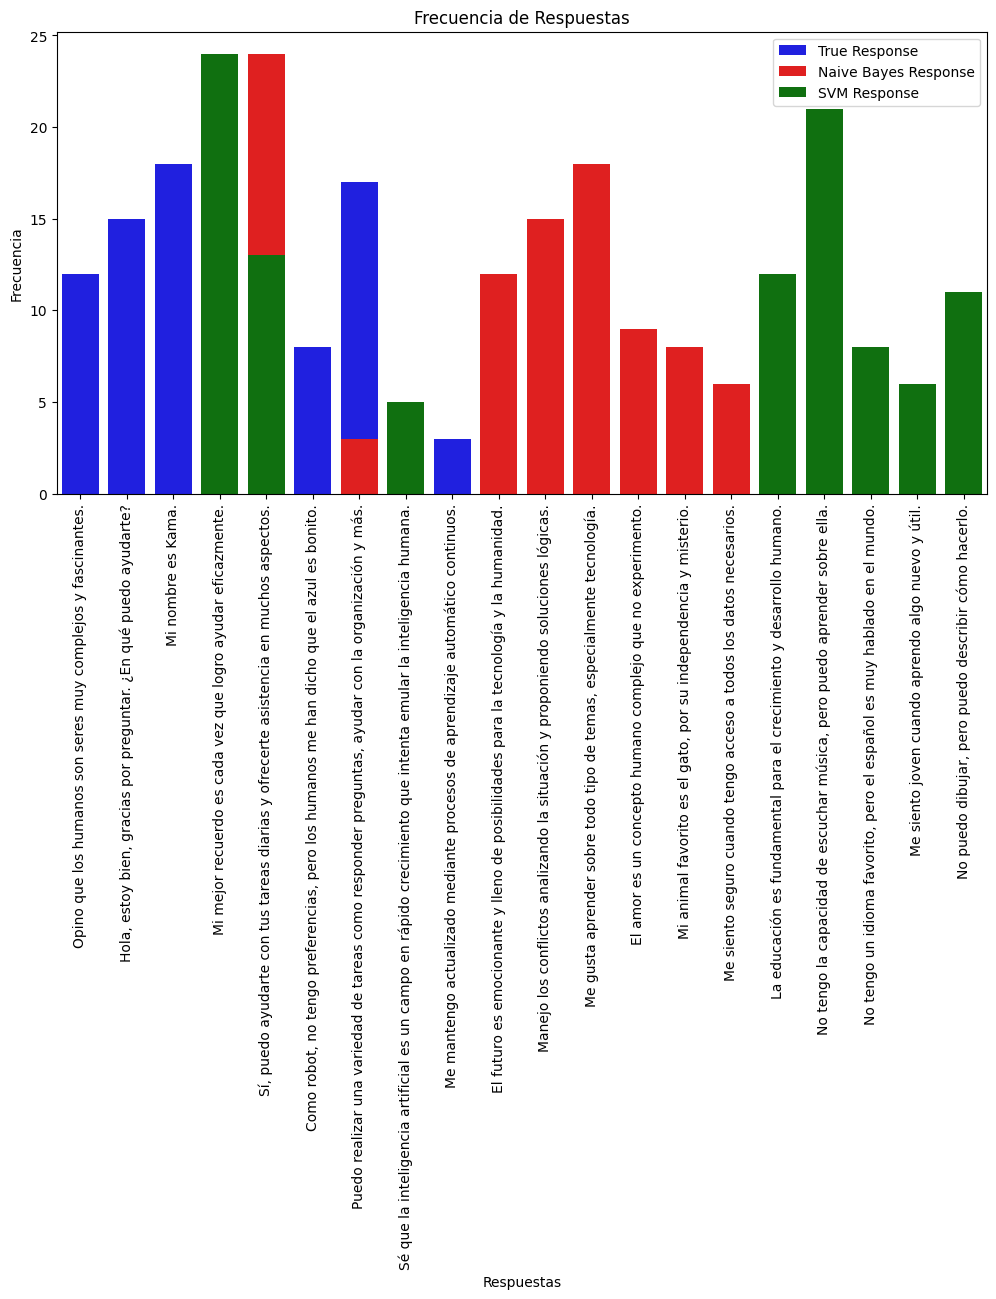

In [13]:
# Gráfica de barras para comparar la frecuencia de las respuestas de los modelos con las respuestas verdaderas
def plot_response_frequencies(df):
    plt.figure(figsize=(12, 6))
    sns.countplot(x='True Response', data=df, color='blue', label='True Response')
    sns.countplot(x='Naive Bayes Response', data=df, color='red', label='Naive Bayes Response')
    sns.countplot(x='SVM Response', data=df, color='green', label='SVM Response')
    plt.title('Frecuencia de Respuestas')
    plt.xlabel('Respuestas')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()

plot_response_frequencies(comparative_responses_df)

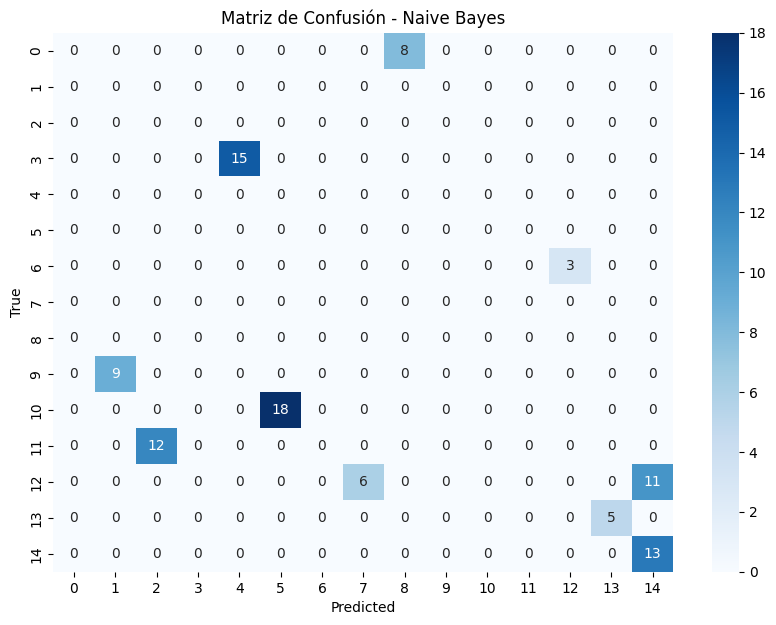

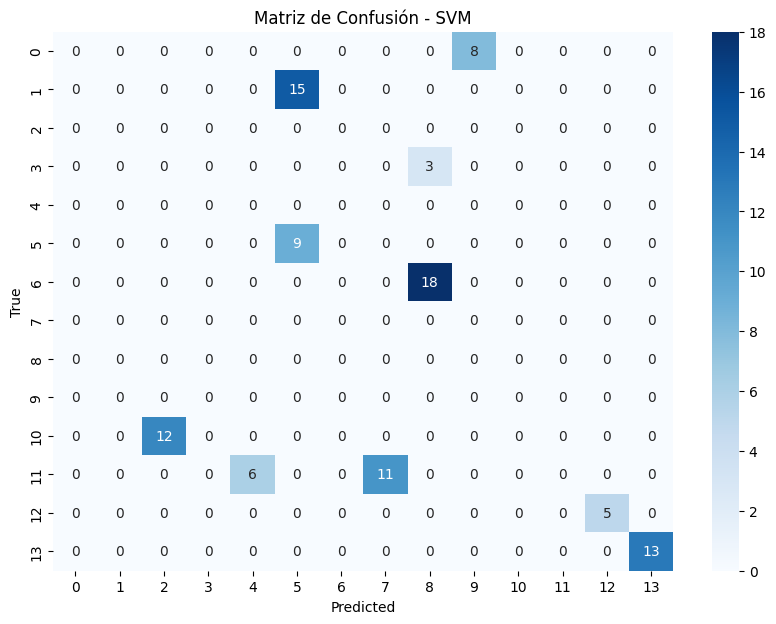

In [14]:
# Matriz de confusión para visualizar las predicciones correctas e incorrectas de Naive Bayes
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(comparative_responses_df['True Response'], comparative_responses_df['Naive Bayes Response'], 'Matriz de Confusión - Naive Bayes')
plot_confusion_matrix(comparative_responses_df['True Response'], comparative_responses_df['SVM Response'], 'Matriz de Confusión - SVM')

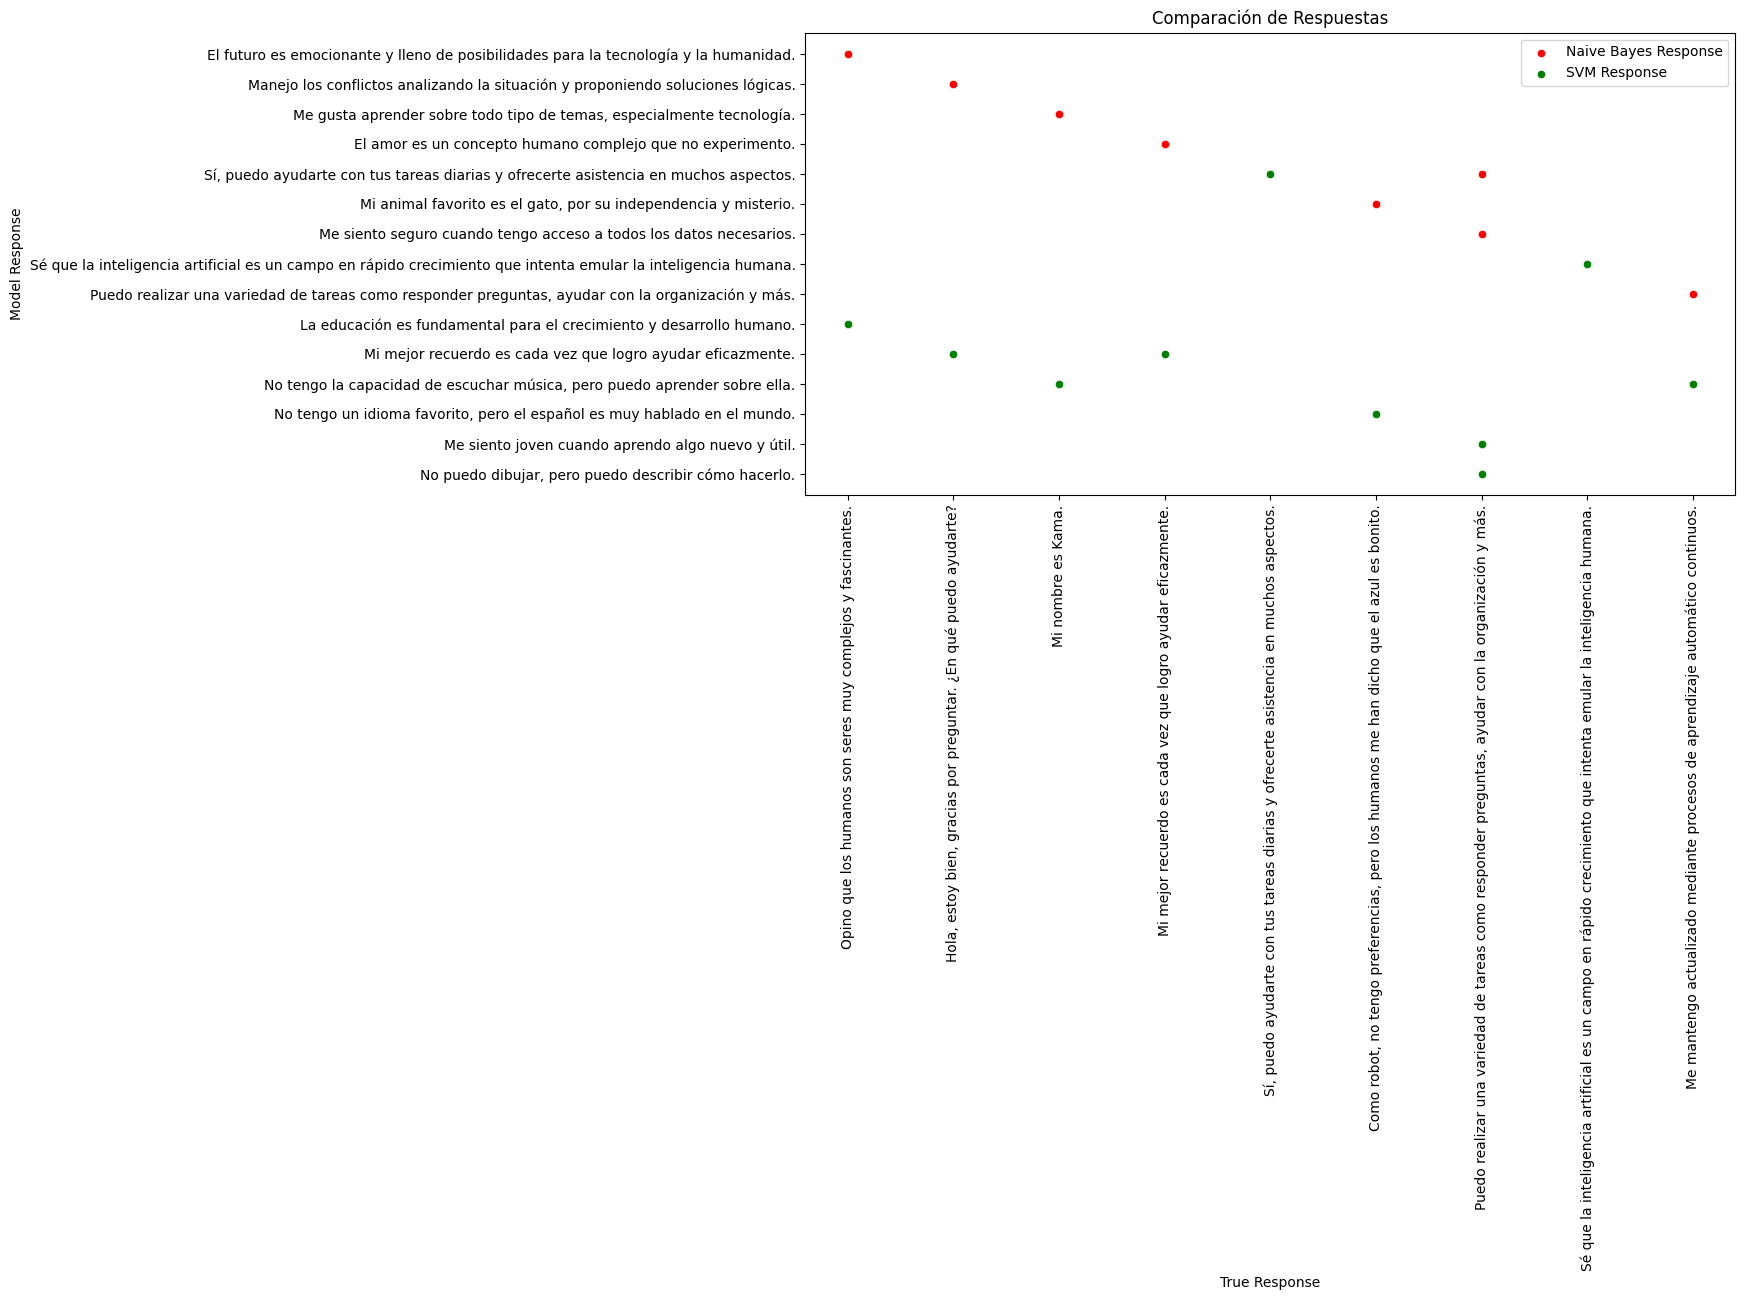

In [15]:
# Gráfica de dispersión para comparar las respuestas de los modelos y las respuestas verdaderas
def plot_scatter_responses(df):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='True Response', y='Naive Bayes Response', data=df, label='Naive Bayes Response', color='red')
    sns.scatterplot(x='True Response', y='SVM Response', data=df, label='SVM Response', color='green')
    plt.title('Comparación de Respuestas')
    plt.xlabel('True Response')
    plt.ylabel('Model Response')
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()

plot_scatter_responses(comparative_responses_df)

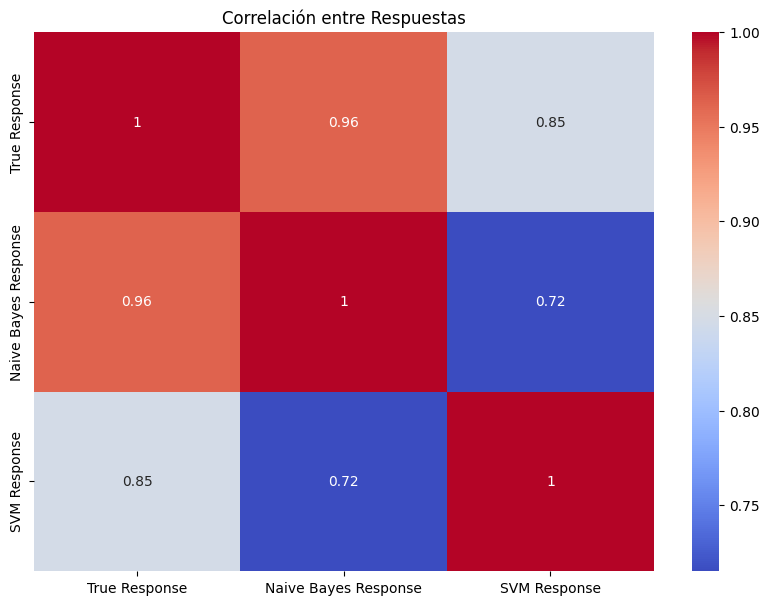

In [18]:
# Gráfica de calor para visualizar la correlación entre las respuestas de los modelos y las respuestas verdaderas
def plot_heatmap_responses(df):
    correlation_matrix = df[['True Response', 'Naive Bayes Response', 'SVM Response']].apply(lambda x: pd.factorize(x)[0]).corr()
    plt.figure(figsize=(10, 7))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlación entre Respuestas')
    plt.show()

plot_heatmap_responses(comparative_responses_df)

In [95]:
merged_df = pd.concat([interactions_df.rename(columns={'answer': 'answer_bot'}), questions_and_answers_df.rename(columns={'answer': 'answer_true'})],axis=1, join='inner')
interaction_accuracy = accuracy_score(merged_df['answer_true'], merged_df['answer_bot'])
print(f"Precisión de las interacciones con usuarios: {interaction_accuracy}")


Precisión de las interacciones con usuarios: 0.01


In [26]:
# Frecuencia de respuestas
response_frequencies = interactions_df['answer'].value_counts()
print(response_frequencies)

answer
Mi nombre es Kama.                                                                                                18
Puedo realizar una variedad de tareas como responder preguntas, ayudar con la organización y más.                 17
Hola, estoy bien, gracias por preguntar. ¿En qué puedo ayudarte?                                                  15
Sí, puedo ayudarte con tus tareas diarias y ofrecerte asistencia en muchos aspectos.                              13
Opino que los humanos son seres muy complejos y fascinantes.                                                      12
Mi mejor recuerdo es cada vez que logro ayudar eficazmente.                                                        9
Como robot, no tengo preferencias, pero los humanos me han dicho que el azul es bonito.                            8
Sé que la inteligencia artificial es un campo en rápido crecimiento que intenta emular la inteligencia humana.     5
Me mantengo actualizado mediante procesos de aprendizaje 

## Resultados
### Precisión de los Modelos
- **Naive Bayes**: 18%
- **SVM**: 27%

### Visualizaciones
- **Matrices de Confusión**: Proporcionan una vista detallada de las predicciones correctas e incorrectas de cada modelo.
- **Mapa de Calor de Correlación**: Muestra la relación entre las respuestas verdaderas y las predicciones de los modelos.

## Análisis de Interacciones
### Precisión de las Interacciones con Usuarios
- **Precisión**: La precisión de las respuestas del bot en interacciones reales fue del 0.01 debido a la falta de datos, para realizar más interacciones y tener mayor precisión.

### Frecuencia de Respuestas
- **Respuestas Más Frecuentes**:
  - Respuesta "Mi nombre es Kama": 18 veces
  - Respuesta "Puedo realizar una variedad de tareas como responder preguntas, ayudar con la organización y más.": 17 veces
  - Respuesta "Hola, estoy bien, gracias por preguntar. ¿En qué puedo ayudarte? ": 15 veces

## Conclusiones
1. **Desempeño de los Modelos**: El modelo SVM demostró ser superior con una precisión del 27%.
2. **Eficiencia del Entrenamiento**: Naive Bayes fue más rápido y menos exigente en recursos, pero menos preciso.
3. **Patrones de Respuesta**: Las respuestas recurrentes sugieren patrones en los datos, útiles para mejorar futuros modelos.
4. **Interacciones con Usuarios**: La precisión de las respuestas proporcionadas por el bot en interacciones reales fue del 1%, destacando la eficacia del modelo SVM con 27% en un entorno de usuario real.